In [2]:
from htm.algorithms import TemporalMemory
from htm_rl.modules.htm.temporal_memory import DelayedFeedbackTM
from htm.bindings.sdr import SDR
import numpy as np
import matplotlib.pyplot as plt
from htm_rl.modules.htm.spatial_pooler import UnionTemporalPooler

In [22]:
from configs import * # I'm so sorry for this...

def make_sdr(pos: tuple, _shape: tuple) -> SDR:
    result = SDR(_shape)
    numpy_res = result.dense
    numpy_res = np.zeros(_shape)
    numpy_res[pos] = 1
    result.dense = numpy_res
    return result

def make_sdrs(array: np.ndarray, _shape: tuple) -> np.ndarray:
    result = np.ndarray((array.size,), dtype=SDR)
    iterator = 0
    for number in array:
        result[iterator] = make_sdr(number, _shape)
        iterator += 1
    return result

def learn_model(tm: TemporalMemory, sdrs: np.ndarray, num_epochs=10) -> list:
    errors = []
    for epoch in range(num_epochs):
        for sdr in sdrs:
            tm.compute(sdr, learn=True)
            tm.activateDendrites(True)
            errors.append(tm.anomaly)
        tm.compute(SDR(sdrs[0].dense.shape), learn=False)
    return errors

def generate_data(n, n_actions, n_states, randomness=1.0, seed=0):
    raw_data = list()
    np.random.seed(seed)
    seed_seq = np.random.randint(0, n_actions, n_states)
    raw_data.append(seed_seq.copy())
    n_replace = int(n_states * randomness)
    for i in range(1, n):
        new_seq = np.random.randint(0, n_actions, n_states)
        if randomness == 1.0:
            raw_data.append(new_seq)
        else:
            indices = np.random.randint(0, n_states, n_replace)
            seed_seq[indices] = new_seq[indices]
            raw_data.append(seed_seq.copy())
    data = [list(zip(range(n_states), x)) for x in raw_data]
    return raw_data, data

def compute(tm, state, action, learn=True):
    context = state_encoder.encode(state)
    active_input = action_encoder.encode(action)

    tm.set_active_context_cells(context)

    tm.activate_basal_dendrites(learn)
    tm.predict_cells()

    tm.set_active_columns(active_input)
    tm.activate_cells(learn)

tp_prev_union = SDR(tp.getNumColumns())

def run(tm, tp, policy, state_encoder, action_encoder,  learn=True):
    tp_input = SDR(tp.getNumInputs())
    tp_predictive = SDR(tp.getNumInputs())
    tp_errors = []
    window_size = 25
    window_error = 0
    counter = 0
    for state, action in policy:
        context = state_encoder.encode(state)
        active_input = action_encoder.encode(action)

        tm.set_active_context_cells(context)

        tm.activate_basal_dendrites(learn)

        tm.set_active_feedback_cells(tp.getUnionSDR().sparse)
        tm.activate_apical_dendrites(learn)
        tm.propagate_feedback()

        tm.predict_cells()

        tm.set_active_columns(active_input)
        tm.activate_cells(learn)

        tp_input.sparse = tm.get_active_cells()
        tp_predictive.sparse = tm.get_correctly_predicted_cells()
        tp.compute(tp_input, tp_predictive, learn)



        apical_predict = tm.predictive_cells_apical
        active_cells = tm.get_active_cells()

        ###
        intersect = np.intersect1d(apical_predict, active_cells)
        union = np.union1d(apical_predict, active_cells)
        window_error += (union.size - intersect.size) / union.size


        current_union = tp.getUnionSDR().sparse.copy()

        if counter % window_size == window_size - 1:
            tp_errors.append(window_error/window_size)
        tp_prev_union.sparse = current_union

        counter += 1

    return tp_errors

tm = DelayedFeedbackTM(**config_tm)
tp = UnionTemporalPooler(**config_tp)
row_data, data = generate_data(4, n_actions, n_states)
errors = []
for i in range(100):
    errors.extend(run(tm, tp, data[0], state_encoder, action_encoder, True))
print(errors)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 0.98, 0.98, 0.9666666666666667, 0.9266666666666665, 0.9266666666666665, 0.9266666666666665, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9466666666666668, 0.9533333333333333, 0.96, 0.9285185185185185, 0.9285185185185185, 0.9285185185185185, 0.9285185185185185, 0.9285185185185185, 0.9285185185185185, 0.9285185185185185, 0.9285185185185185, 

In [8]:

print(f'row: {row_data[:1]}\n')
print(f'data: {data[:1]}\n')

row: [array([0, 3, 1, 0, 3, 3, 3, 3, 1, 3, 1, 2, 0, 3, 2, 0, 0, 0, 2, 1, 2, 3,
       3, 2, 0])]

data: [[(0, 0), (1, 3), (2, 1), (3, 0), (4, 3), (5, 3), (6, 3), (7, 3), (8, 1), (9, 3), (10, 1), (11, 2), (12, 0), (13, 3), (14, 2), (15, 0), (16, 0), (17, 0), (18, 2), (19, 1), (20, 2), (21, 3), (22, 3), (23, 2), (24, 0)]]



In [4]:
tm = DelayedFeedbackTM(**config_tm)
tp = UnionTemporalPooler(**config_tp)
errors = run(tm, tp, data[0], state_encoder, action_encoder)
print(data)
print(errors)

AttributeError: 'int' object has no attribute 'size'

Text(0.5, 1.0, 'tp_one_policy_errors')

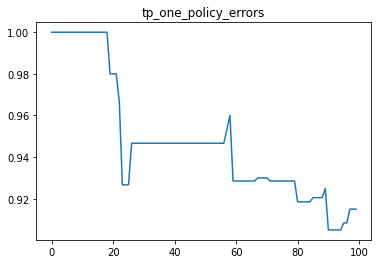

In [23]:
plt.plot(range(len(errors)), errors)
plt.title('tp_one_policy_errors')

In [15]:
class MyUTP:
    _initial_pooling = 1
    _pooling_decay = 0.1
    def __init__(self, _shape: tuple):
        self._union_sdr = SDR(_shape)
        self._pooling_activations = np.zeros(_shape)
        self._shape = _shape

    def pooling_decay_step(self):
        self._pooling_activations[self._pooling_activations != 0] -= self._pooling_decay
        self._pooling_activations = self._pooling_activations.clip(0, float('inf'))

    def compute(self, _sdr: SDR):
        self.pooling_decay_step()
        self._pooling_activations[_sdr.sparse] += self._initial_pooling

        self._union_sdr.dense = self._pooling_activations != 0


tp_shape = [input_columns * cells_per_column]

my_utp = MyUTP(tp_shape)
my_utp.compute(make_sdr((1,), tp_shape))
my_utp.compute(make_sdr((3,), tp_shape))
my_utp.compute(make_sdr((4,), tp_shape))
my_utp.compute(make_sdr((1,), tp_shape))
print(my_utp._pooling_activations)

[0.  1.7 0.  0.8 0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 